# Final Project

1. Name: Jenny Ding, Betty Pu
1. Create a new ChatGPT chat called "Final Project" that contains all the prompts you used for this problem set. **After you've completed your assignment**, click the share button and paste the URL in Markdown format [here](https://chat.openai.com/share/97414245-8033-4104-8214-e4cf2234167b) (shared ChatGPT links don't auto-update with subsequent queries).

### Reference
Data and Interpretation
1. https://www.bloomberg.com/news/articles/2023-12-14/fed-prepares-shift-to-rate-cuts-in-2024-as-price-pressures-fade
2. https://www.newyorkfed.org/markets/reference-rates/bgcr

Code Reference:
PS3, PS4, Data Camp

# Executive Summary
Utilizing historical data from 2005-01-31 to 2022-12-30, we applied ARIMA, Exponential Smoothing, and Time Series models to predict the General Collateral Treasury Repo Rate based on Fed Fund Rates and Mortgage-Backed Securities (MBS) Repo Rate. The General Collateral Treasury Repo Rate is a vital benchmark in financial markets signifying the cost of borrowing for institutional investors using Treasury securities as collateral. 
While our models showed potential, the predictive accuracy fell short of meeting the desired benchmarks for forecasting the Treasury Repo Rate, Fed Fund Rates, and MBS Repo Rate. The complexities inherent in the data, including intricate market dynamics and unpredictable external factors, posed challenges in accurately capturing the future movements of these critical financial indicators. The inherent volatility and non-linear patterns within these rates proved difficult to capture comprehensively. As a result, the forecasting outcomes might not provide the level of precision necessary for stakeholders to make fully informed decisions in financial markets.

# Introduction

- Context of data: Financial Data
- Source of data: FRED (Federal Reserve Saint Louis) https://fred.stlouisfed.org/
- Research questions: Is Treasury repo predictable? What is the best way to predict it?

# 1. Data preparation (tidy) 

In [302]:
# Import all the Python packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_predict

In [303]:
# Load the data
fed_data = pd.read_csv("output.csv", parse_dates = ['Date'], index_col = 'Date')
print(fed_data.head())

              MBS  Treasury  Federal Fund Rate
Date                                          
2005-01-03  2.314     2.176               2.31
2005-01-04  2.285     2.145               2.25
2005-01-05  2.285     2.136               2.25
2005-01-06  2.297     2.180               2.25
2005-01-07  2.283     2.123               2.24


- The frequency of our data is Business daily. For evaluation and forecasting purposes, we decide to use monthly frequency.
- The variable we will be examining is Treasury rate.

In [304]:
# Resample to monthly frequency and sum the values
df_monthly = fed_data.resample('M').mean()

# 2. Plot the data (visualise)

## Visualize the Raw Data

### Seasonal Decomposition

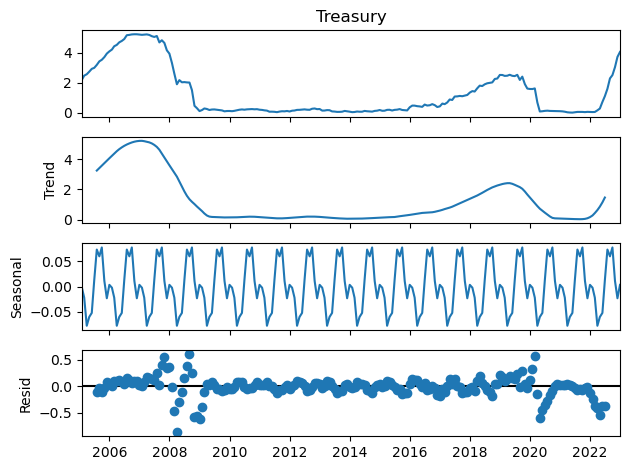

In [305]:
fig = seasonal_decompose(df_monthly['Treasury'], model='additive').plot()

- We observe an obvious trend. We also observe seasonality. However, the magnitude is negligable.
- According to the residuals visualization, the treasury Repo rate is highly volatile in late 2007 to early 2009 during the Global Financial Crisis. There was large movement in the Treasury repo rate during this period because the Treasury repo rate follows the federal funds rate closely, and the Fed was adjusting policy rate lower to stimulate the economy during early 2007. Similar large residuals appeared during COVID when the Fed initially lowers the federal funds rate to cope with COVID recession and rapidly hike rate since March 2022 to tame inflation.

# 3. Forecasting and Modeling
- Specify and estimate forecasts using 1) Simple time series and 2) ARIMA model. 
- Visualize forecasts
- Evaluate the forecasting accuracy of all models and compare
- Forecast into the future using the model of your choice, justifying this choice

## 3.1 Simple Forecasting

### Splitting data to training and test

Training dataset: 181, Test dataset: 36


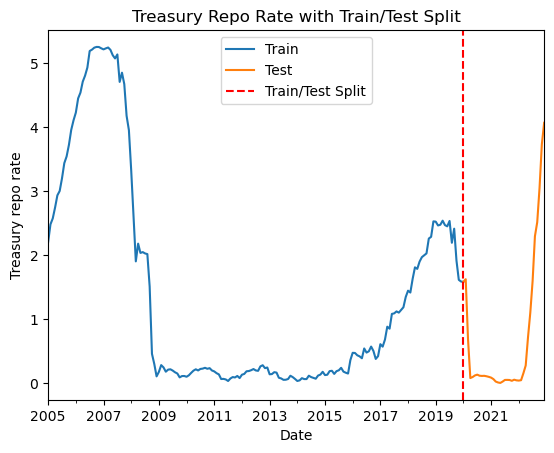

In [306]:
#Treasury = merged_daily['Treasury']
train = df_monthly['2005-01-31':'2020-01-31']
test = df_monthly['2020-01-31':'2022-12-31']
print('Training dataset: %d, Test dataset: %d' % (len(train), len(test)))

# Plot the train and test data
train['Treasury'].plot(label='Train')
test['Treasury'].plot(label='Test')

# Add a vertical bar to indicate the train/test split
split_date = '2020-01-31'
plt.axvline(x=split_date, color='red', linestyle='--', label='Train/Test Split')

plt.title('Treasury Repo Rate with Train/Test Split')
plt.ylabel('Treasury repo rate')
plt.xlabel('Date')
plt.legend() 
plt.show()

### Train the model and estimate forecast using Mean, Naive, and Seasonal Naive methods

In [307]:
# Add mean forecast and naive forcast columns to test data 
test["mean_forecast_Tre"] = train["Treasury"].values.mean()
test["naive_forecast_Tre"] = train["Treasury"].values.take(-1)

# Add seasonal naive forecast
last_month = train["Treasury"].tail(12).values
seasonal_naive_values=[]
for i in range(0, len(test)):
    index = i % len(last_month)
    seasonal_naive_values.append(last_month[index])
test["seasonal_naive_forecast_Tre"] = seasonal_naive_values

/var/folders/1h/35wbm1092xnchvv0w4lq5t2h0000gn/T/ipykernel_10386/3747695041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["mean_forecast_Tre"] = train["Treasury"].values.mean()
/var/folders/1h/35wbm1092xnchvv0w4lq5t2h0000gn/T/ipykernel_10386/3747695041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["naive_forecast_Tre"] = train["Treasury"].values.take(-1)
/var/folders/1h/35wbm1092xnchvv0w4lq5t2h0000gn/T/ipykernel_10386/3747695041.py:11: SettingWithCopyWarning: 
A value is trying to be s

### Visualize the forecast for the test data

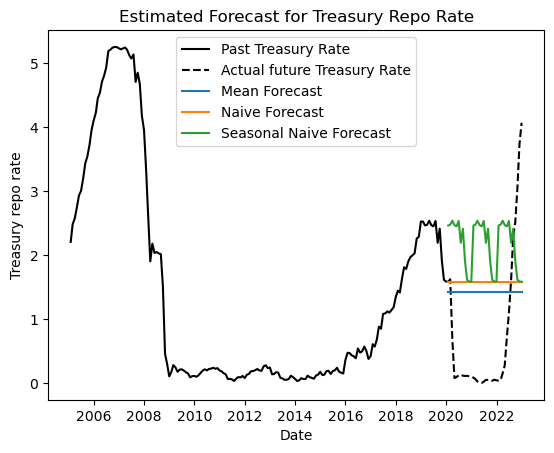

In [308]:
# Plot the train values
plt.plot(train.index, train['Treasury'], label='Past Treasury Rate', color = 'Black')

# Plot the test values
plt.plot(test.index, test['Treasury'], label='Actual future Treasury Rate', color = 'Black', linestyle = 'dashed')

# Plot the mean forecast
plt.plot(test["mean_forecast_Tre"], label='Mean Forecast')

# Plot the naive forecast
plt.plot(test["naive_forecast_Tre"], label='Naive Forecast')

# Plot the seasonal naive forecast
plt.plot(test["seasonal_naive_forecast_Tre"], label='Seasonal Naive Forecast')

# Add title and labels
plt.xlabel('Date')
plt.ylabel('Treasury repo rate')
plt.title('Estimated Forecast for Treasury Repo Rate')
plt.legend()
plt.show()

From the plot, all three forecasting rate quite unpredictable of actual rate of the test set. The Mean forcasting method is closest to the actual value.

### Evaluating forecast accuracy using MSE and RMSE values
- In addition to visualization, we evaluate the forecast accuracy.

In [309]:
# Mean Method
test['residual'] = test['Treasury'] - test['mean_forecast_Tre']
mse_mean = test['residual'].pow(2).mean()
rmse_mean = math.sqrt(mse_mean)

# Naive Method
test['residual'] = test['Treasury'] - test['naive_forecast_Tre']
mse_naive = test['residual'].pow(2).mean()
rmse_naive = math.sqrt(mse_naive)

# Seasonal Naive Method
test['residual'] = test['Treasury'] - test['seasonal_naive_forecast_Tre']
mse_seasonal_naive = test['residual'].pow(2).mean()
rmse_seasonal_naive = math.sqrt(mse_seasonal_naive)

/var/folders/1h/35wbm1092xnchvv0w4lq5t2h0000gn/T/ipykernel_10386/4259113321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residual'] = test['Treasury'] - test['mean_forecast_Tre']
/var/folders/1h/35wbm1092xnchvv0w4lq5t2h0000gn/T/ipykernel_10386/4259113321.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residual'] = test['Treasury'] - test['naive_forecast_Tre']
/var/folders/1h/35wbm1092xnchvv0w4lq5t2h0000gn/T/ipykernel_10386/4259113321.py:12: SettingWithCopyWarning: 
A value is trying t

In [310]:
# Create a DataFrame to store the results
results = pd.DataFrame({
    'Method': ['Mean Method', 'Naive method', 'Seasonal Naive Method'],
    'MSE': [mse_mean, mse_naive, mse_seasonal_naive],
    'RMSE': [rmse_mean, rmse_naive, rmse_seasonal_naive]
})

results = results[['Method', 'MSE', 'RMSE']]
results

,Method,MSE,RMSE
0,Mean Method,1.761819,1.327335
1,Naive method,2.020919,1.421590
2,Seasonal Naive Method,3.868704,1.966902


The Mean forcasting method have the lowest root mean squared error relative to the other methods, we can conclude that the Mean method deliver the highest accuracy.

## Forecasting into the actual future using the Mean method

In [311]:
# We will be using all available data to predict into the future
## Our train set is data from 2005 to 2022
train = df_monthly['2005-01-31':'2022-12-31']

## We will forecast two years into the future using the train data.
test = {
    'Date': pd.date_range(start='2022-12-31', end='2024-12-31'),
    'Forecast': train["Treasury"].values.mean()
}
forecast = pd.DataFrame(test)
forecast.set_index('Date', inplace=True)

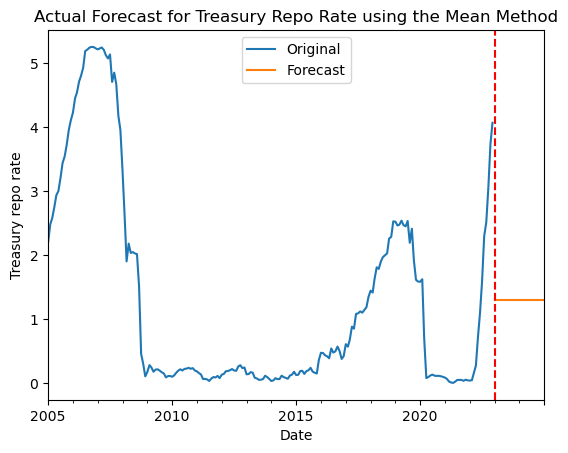

In [312]:
# Plot the actual forecast
from statsmodels.graphics.tsaplots import plot_predict
fig, ax = plt.subplots()

# Plot the Actual Data
train['Treasury'].plot(ax=ax,label='Original', linestyle='-')

# Plot the out-of-sample Forecast (actual forecast)
forecast.plot(ax=ax,label='Forecast', linestyle='-')

# Add title and labels
plt.legend(["Original", "Forecast"])
plt.xlabel('Date')
plt.ylabel('Treasury repo rate')
plt.title('Actual Forecast for Treasury Repo Rate using the Mean Method')
plt.legend()
split_date = '2022-12-31'
plt.axvline(x=split_date, color='red', linestyle='--', label='Actual/Forecast')
plt.show()

## 3.2 ARIMA Model


### Test if data is stationary

In [313]:
# Assuming your time series data is stored in 'time_series_data'
# Run the ADF test on the time series
resultTreasury=adfuller(df_monthly['Treasury'])

# Print the test statistic and the p-value
## Treasury ADF
print('ADF Statistic:', resultTreasury[0])
print('p-value:', resultTreasury[1])

ADF Statistic: -2.9528446408493343
p-value: 0.03953898552467147


Because p-value is smaller than 0.05, we can conclude that our data is stationary.


### Plot ACF and PACF to find the order of the ARIMA model
- ARIMA model has orders (p, d, q)
- p is the order of the autoregressive part
- d is the degree of first differencing involved
- q is the order of the moving average part.

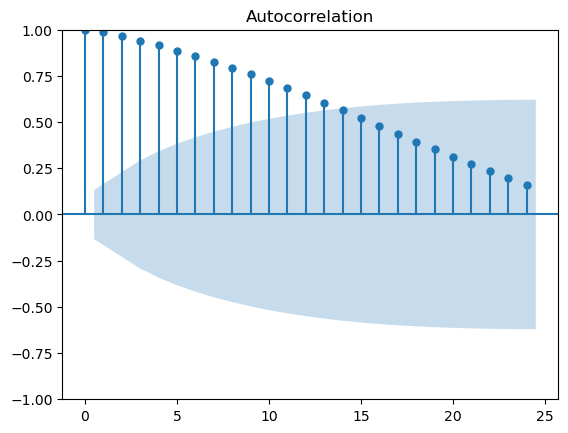

In [314]:
plot_acf(df_monthly['Treasury'])
plt.show()

- ACF tells us the order of an MA model.
- A lot of autocorrelations are significantly non-zero, thus the data is non-random.
- We do not observe obvious cutoff for ACF.
- q = 0

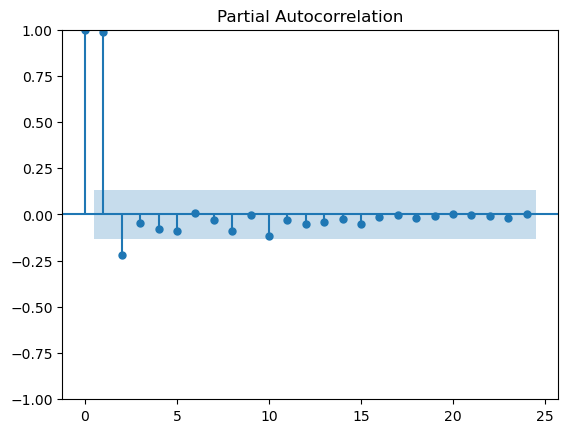

In [315]:
plot_pacf(df_monthly['Treasury'])
plt.show()

- There're significant spikes at lag 1 and lag 2 in the PACF, thus p = 1 or 2.

### Building the model

#### Autoregression: ARIMA with order (1, 0, 0)

In [316]:
arima_model_train = ARIMA(df_monthly['Treasury'], order = (1,0,0))

arima_fit = arima_model_train.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Treasury   No. Observations:                  216
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  41.350
Date:                Tue, 19 Dec 2023   AIC                            -76.699
Time:                        17:02:53   BIC                            -66.574
Sample:                    01-31-2005   HQIC                           -72.608
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3507      2.157      1.090      0.276      -1.877       6.578
ar.L1          0.9931      0.009    114.787      0.000       0.976       1.010
sigma2         0.0391      0.002     21.279      0.000       0.036       0.043
===================================================================================
Ljung-Box (L1) (Q):                  56.53   Jarque-Bera (JB):               719.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -1.44
Prob(H) (two-sided):                  0.94   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Autoregression: ARIMA with order (2, 0, 0)

In [317]:
arima_model_train = ARIMA(df_monthly['Treasury'], order = (2,0,0))

arima_fit = arima_model_train.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Treasury   No. Observations:                  216
Model:                 ARIMA(2, 0, 0)   Log Likelihood                  74.346
Date:                Tue, 19 Dec 2023   AIC                           -140.693
Time:                        17:02:53   BIC                           -127.192
Sample:                    01-31-2005   HQIC                          -135.238
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8724      1.317      1.422      0.155      -0.708       4.453
ar.L1          1.5083      0.032     47.524      0.000       1.446       1.571
ar.L2         -0.5183      0.031    -16.534      0.000      -0.580      -0.457
sigma2         0.0287      0.001     21.844      0.000       0.026       0.031
===================================================================================
Ljung-Box (L1) (Q):                   1.80   Jarque-Bera (JB):               678.18
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -1.20
Prob(H) (two-sided):                  0.98   Kurtosis:                        11.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The AIC value is more negative for ARIMA model with order (2,0,0), which means that ARIMA (2,0,0) is a better-fitting model.

### Forecast for the future (January 2023 - December 2024) with ARIMA (2,0,0)

In [318]:
# Fit all the available data using ARIMA
arima_model = ARIMA(df_monthly['Treasury'], order = (2,0,0))
arima_fit = arima_model.fit()
fitted = arima_fit.fittedvalues

#### Comparing ARIMA model with the Mean method

In [319]:
df_monthly['residual'] = df_monthly['Treasury'] - fitted
mse_ar = df_monthly['residual'].pow(2).mean()
rmse_ar = math.sqrt(mse_ar)

# Create a DataFrame to store the results
results = pd.DataFrame({
    'Method': ['Mean Method', 'ARIMA model'],
    'MSE': [mse_mean, mse_ar],
    'RMSE': [rmse_mean, rmse_ar]
})

results = results[['Method', 'MSE', 'RMSE']]
results

,Method,MSE,RMSE
0,Mean Method,1.761819,1.327335
1,ARIMA model,0.029357,0.171340


#### Both the MSE and RMSE values are much smaller for ARIMA than for the mean method. Therefore, ARIMA is the preferred model for forecast.

/Users/dd/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['label']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


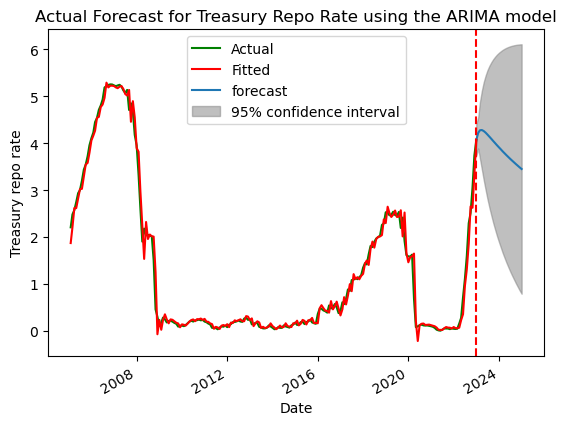

In [320]:
fig,ax = plt.subplots()
# Actual
plt.plot(df_monthly['Treasury'], color = 'green', label = 'Actual')

# Fitted
plt.plot(fitted, color = 'red', label = 'Fitted')

# Forecast
plot_predict(arima_fit, start='2022-12-31', end='2024-12-30', ax=ax,label = "Forecast Values")

# Add title and labels
plt.xlabel('Date')
plt.ylabel('Treasury repo rate')
plt.title('Actual Forecast for Treasury Repo Rate using the ARIMA model')
split_date = '2022-12-31'
plt.axvline(x=split_date, color='red', linestyle='--', label='Actual/Forecast')
plt.show()

- ARIMA model with order (2,0,0) shows that the model fits our data really well. The forecast shows a decreasing treand in Treasury Repo Rate from 2023 - 2024. In real life, the Fed has announced a pause in rate hike due to stabalizing inflation in the December FOMC meeting and the market expects a decrease in the federal funds rate to 4.6% down from 5.1% by Q4 2024 (Bloomberg, 2023), which is a little less aggresive than our prediction. 

# Conclusion


- In this project, we fitted and forecasted Treasury Repo Rates using both simple forecast methods and the ARIMA model. We found out that ARIMA model better fits the actual Treasury data.
- However, past performance is no guarantee of future results in economics. There are many other variables deciding Fed's interest rate policy paths, such as Fed's long-term inflation goal and unemployment. Therefore, we are cautious of applying this model in real-life investment decisions.
- The inherent volatility and non-linear patterns within these rates proved difficult to capture comprehensively. As a result, the forecasting outcomes might not provide the level of precision necessary for stakeholders to make fully informed decisions in financial markets.

# Appendix
Fun Staff: 
- If you are interested to learn more about Treasury Rates and Fed Fund Rates, please read Jenny's Seminar Paper!
- To learn more about Fed Fund rates, please check this website: https://www.forbes.com/advisor/investing/fed-funds-rate-history/
- To learn more about Treatury rates, please check: https://www.federalreserve.gov/pubs/feds/2012/201221/201221pap.pdf

Other things we've tried:
- We tried exponential smoothing but we aren't satisfied with the predicted results.

## 3.3 Exponential smoothing with seasonality


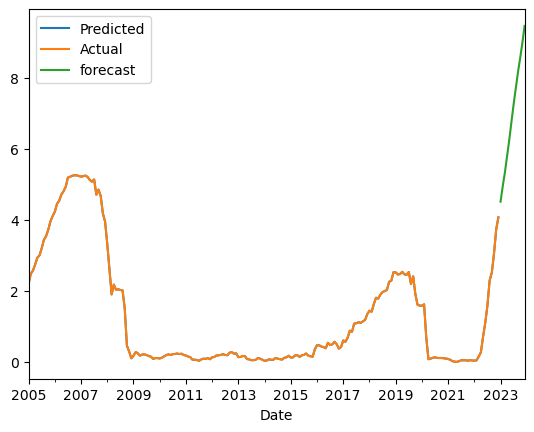

In [321]:
model = ExponentialSmoothing(df_monthly['Treasury'], trend='add', seasonal='add', seasonal_periods=12)
fitted_model = model.fit()
forecast_periods = 12
forecast = fitted_model.forecast(steps=forecast_periods)
df_monthly['Treasury'].plot(label='Predicted')
df_monthly['Treasury'].plot(label='Actual')
forecast.plot(label='forecast')
plt.legend()
plt.show()


## 3.4 Time Series OLS Regression Model


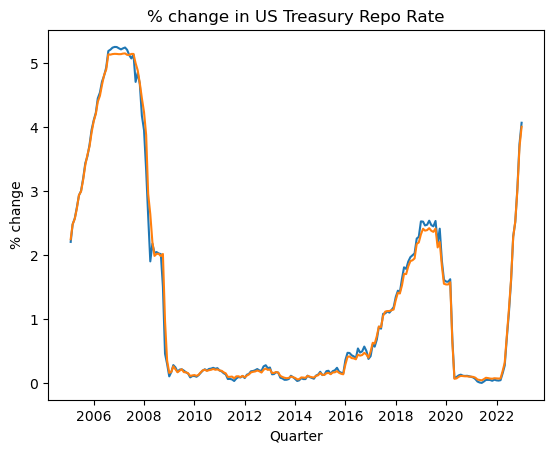

In [322]:
# Fit the Simple Exponential Smoothing model
X = train[['Federal Fund Rate', 'MBS']]
y = train['Treasury']
## fit a OLS model with intercept on TV and Radio
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()

plt.plot(train.index, train['Treasury'])
plt.plot(est.fittedvalues)
plt.xlabel('Quarter')
plt.ylabel('% change')
plt.title('% change in US Treasury Repo Rate')
plt.show()


## Visualize the correlation

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2005-01-31 to 2022-12-31
Freq: M
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MBS                216 non-null    float64
 1   Treasury           216 non-null    float64
 2   Federal Fund Rate  216 non-null    float64
 3   residual           216 non-null    float64
dtypes: float64(4)
memory usage: 16.5 KB
None
                        MBS  Treasury  Federal Fund Rate  residual
MBS                1.000000  0.876543           0.815254 -0.008956
Treasury           0.876543  1.000000           0.668970  0.025574
Federal Fund Rate  0.815254  0.668970           1.000000  0.026275
residual          -0.008956  0.025574           0.026275  1.000000


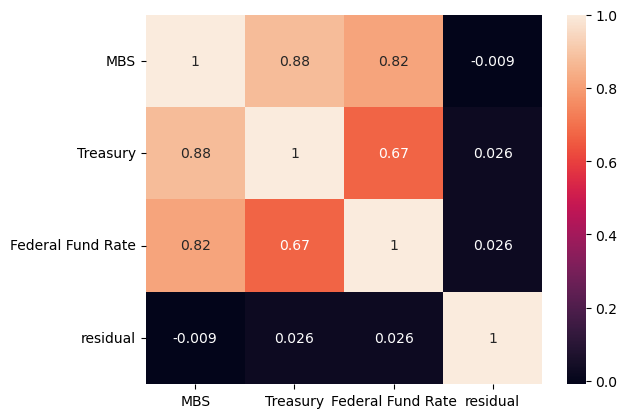

In [323]:
data = df_monthly
# Inspect data here
print(data.info())

# Calculate year-end prices here
annual = data.resample('M').last()

# Calculate annual returns here
annual_change = annual.pct_change()

# Calculate and print the correlation matrix here
correlations = annual_change.corr()
print(correlations)

# Visualize the correlations as heatmap here
sns.heatmap(correlations, annot=True)
plt.show();